In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt

# 建立Policy Gradient模型

In [2]:
class Policy_Gradient:
    
    def __init__(
        self, 
        n_actions, 
        n_states, 
        gamma = 0.9, #遠見程度
        epsilon = None,  #保守程度，越大就越容易用Q值大小來採取行動；越小則越容易產生隨機行動
        epsilon_increase = None,
        learning_rate = 0.001, #神經網路的更新率
        #memory_size = 50, #####
        batch_size = 32, #####
        nueron_num = 10
    ):
    
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        #self.epsilon_max = epsilon #####
        #self.epsilon_increase = epsilon_increase #####
        #self.epsilon = 0 if epsilon_increase is not None else epsilon #####
        self.lr = learning_rate
        #self.memory_size = memory_size #####
        #self.memory_counter = 0 #####
        self.batch_size = batch_size ####
        self.nueron_num = nueron_num
        
        ##### initialize memory
        """
        
        """
        self.past_state, self.past_action, self.past_reward = [], [], []
        #self.action_one_hot = np.zeros(self.n_actions, dtype=np.int32)

        """

        """
        
        tf.reset_default_graph() ## 重新 build graph 需要跑這行
        self.sess = tf.Session() #宣告session
        #輸入current state
        self.state_input = tf.placeholder(shape = [None, self.n_states], 
                                          name = 'state_input',
                                          dtype = tf.float32)
        """
        輸入real action和神經網路的output act_proba算cross entropy當作更新方向
        以超級瑪莉的遊戲為例 action = [上, 下, 左, 右] 如果實際action為向左則
        action = [0, 0, 1, 0]。
        也可以將這四個動作用0, 1, 2 ,3代表，如此的話只需要用一維來存取動作，也就是輸
        入shape = [None, 1]，那後面再算cross entropy的話就要用tf.nn.sparse_
        softmax_cross_entropy_with_logits，大家也可以試著改寫看看。
        """    
        self.real_action = tf.placeholder(shape = [None, self.n_actions], 
                                          name = 'real_action',
                                          dtype = tf.float32)
        """
        但是有時候產生的動作會帶來好的效果或壞的效果並且程度不一，因此loss不能光用神經網路的
        輸出action_proba和real action的cross entropy代表，因此這邊乘上action_reward
        來校正loss。例如某個動作很有幫助那必然會產生很大的action_reward，因此乘上很大的
        action_reward即可加大loss讓此動作之後產生的機率被放大；相反的，某個動作如果產生很
        好的效果反而會帶來負的action_reward使得loss變負的，讓更新方向相反使得之後輸出此動
        作的機會減少。
        """
        self.Vt = tf.placeholder(shape= [None, ], 
                                            name="action_reward",
                                            dtype = tf.float32)
        #搭建神經網路
        with tf.variable_scope('Actor'):
            self.act_mean_std = self.build_network(self.nueron_num, Trainable = True, \
                             scope = 'net_eval') 
            
        
        #管理神經網路的parameters
        self.Actor_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/net_eval')
        
        
        #loss
        """
        算出 “神經網路輸出的動作機率”與 “實際動作”的cross entropy當作loss，但是更新的方向和力道就利用action
        reward來決定。例如，這一回合產生的所有動作組合如果得到很好的reward，那就應該讓神經網路的輸出機率更靠近實
        際輸出的結果，因此cross_entropy和action_reward相乘的到的loss就更大，更新力度就更大。相反的，這一回
        合產生的所有動作組合如果得到負的reward，那就應該讓神經網路輸出動作的機率更遠離實際輸出結果，在這樣的狀況
        下，cross_entropy和action_reward相乘的到的loss就會得到負的，神經網路的參數更新方向就會往反方向。
        """
        #self.cross_entropy = tf.reduce_sum(-tf.log(self.act_proba)*self.real_action, axis=1)
        #self.loss = tf.reduce_sum(self.cross_entropy*self.action_reward)
        dist = tf.contrib.distributions.Normal(loc=self.act_mean_std[:,0:self.n_actions], 
                             scale=self.act_mean_std[:,self.n_actions:2*self.n_actions])
        #log_prob = dist.log_prob()
        self.cross_entropy = -dist.log_prob(self.real_action)
        
        
        self.loss = self.cross_entropy*self.Vt[:, np.newaxis]
        
        
        self.train = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, var_list=self.Actor_eval_params)
    
        self.sess.run(tf.global_variables_initializer()) #將神經網路初始化
    
    def write_memory(self, current_state, reward, action): #####
        
        #action_one_hot = self.action_one_hot.copy()
        #action_one_hot[action] = 1
        self.past_state.append(current_state)
        self.past_action.append(action)
        self.past_reward.append(reward)
    
    
    def build_network(self, neuron_num, Trainable, scope): 
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            
            x1_h1 = tf.layers.dense(inputs = self.state_input, units = neuron_num, \
                   activation = tf.nn.tanh, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable) 
            x1_h2 = tf.layers.dense(inputs = x1_h1, units = neuron_num, \
                   activation = tf.nn.tanh, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable)
            
            x2_h1 = tf.layers.dense(inputs = self.state_input, units = neuron_num, \
                   activation = tf.nn.relu, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable) 
  
            
             
            #在continuous的版本output為動作的機率分佈，這邊以機率分布的mean值和std
            #當成神經網路的輸出值。這邊輸出值為mean1, mean2,... std1, std2,...。
             
            mean = tf.layers.dense(inputs = x1_h2,
                                   units = self.n_actions, 
                                     activation = tf.nn.tanh, 
                                     kernel_initializer=init_w, 
                                     bias_initializer=init_b, 
                                     trainable=Trainable)*1
            std = tf.layers.dense(inputs = x2_h1,
                                     units = self.n_actions, 
                                     activation = tf.nn.sigmoid, 
                                     kernel_initializer=init_w, 
                                     bias_initializer=init_b, 
                                     trainable=Trainable)*1
            output = tf.concat(axis=1,values=[mean, std])
            
            #tf.stack([mean, std], axis=1)
        return output #輸出‘不同動作’對應的Q值 
               
 
            
    def choose_action(self, current_state):
        
        act_mean_std = self.sess.run(self.act_mean_std, feed_dict={self.state_input: current_state[np.newaxis, :]})
        """
        
        """
        self.action = np.zeros(self.n_actions)
        
        for i in range(self.n_actions):
            #輸出動作從normal distribution去隨機抽樣ㄙ
            self.action[i] = np.random.normal(act_mean_std[0,i], 
                                              act_mean_std[0,self.n_actions+i])
   
        return self.action
    
    def learn(self): #####
        
        #用reward算出更新向量
        Vt = self.calculate_Vt()
        
        self.past_state = np.vstack(self.past_state)
        self.past_action = np.array(self.past_action)
        Vt = np.array(Vt)
        size = self.past_state.shape[0]
        #將整個episode的資料放進來做更新
        for index in self.index_generator(size):
            cost, _ =self.sess.run([self.loss , self.train], feed_dict={
                 self.state_input: self.past_state[index,:],  # shape=[None, n_state]
                 self.real_action: self.past_action[index,:],  # shape=[None, n_actions]
                 self.Vt: Vt[index]  # shape=[None, ]
            })

        #更新完後將記憶庫清空
        self.past_state, self.past_action, self.past_reward = [], [], []    
    
    def calculate_Vt(self):
        # discount episode rewards
        Vt = np.zeros_like(self.past_reward, dtype=np.float64)
        Vt_temp = 0
        for t in reversed(range(0, len(self.past_reward))):
            Vt_temp = self.past_reward[t] + Vt_temp * self.gamma
            Vt[t] = Vt_temp

        # normalize episode rewards
        
        Vt -= np.mean(Vt)
        Vt /= np.std(Vt)
        
        return Vt 
    #前幾回合所要花的步數比較多，因此要一次將所有資訊餵進神經是有困難的，因此利用
    # index generator將資料分batch送進神經網路去更新參數
    def index_generator(self, size):
        i = 0
        while True:
            if (i+1)*self.batch_size< size:
                index = np.arange(i*self.batch_size,(i+1)*self.batch_size)
                i+=1
                yield index
            else:
                index= np.arange(i*self.batch_size,size)
                yield index
                break  
            
        
    def model_save(self, model_name):
        
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))

In [3]:
def training(save_model, model_name):
    step_record = []
    reward_record = []
    for episode in range(1000):
        # initial environment並給出起始的state
        current_state = env.reset()
        step = 0
        total_reward = 0
        while True:
            # 產生環境視窗
            env.render()

            # 根據現在的狀態選擇動作
            action = RL.choose_action(current_state)

            # 產生動作和環境互動後產生下一個狀態、獎勵值及遊戲是否結束
            next_state, reward, done, _ = env.step(action)
            
            position, velocity = next_state
            reward = abs(position + 0.5) + 15*abs(velocity) + reward 

            
            total_reward+= reward
            
            
            # 將資訊存至記憶體
            RL.write_memory(current_state, reward, action)
            
            
            current_state = next_state

            # break while loop when end of this episode
            if done:
                mean_reward = total_reward/step
                RL.learn()
                print('episode:{} steps:{} mean_reward:{}'.format(episode, step, mean_reward))
                step_record.append(total_reward)
                reward_record.append(mean_reward)
                break
            step += 1

    # end of game
    if save_model:
        RL.model_save(model_name)
    print('game over')
    env.close()
    return step_record, reward_record

In [4]:
step_result = []
reward_result = []
env = gym.make('MountainCarContinuous-v0')
env.seed(1)     # reproducible, general Policy gradient has high variance
env = env.unwrapped
RL = Policy_Gradient(n_actions = 1, 
                   n_states = 2,
                   gamma = 0.99,
                   learning_rate = 0.001,
                   batch_size = 1000
                 )
step_record, reward_record = training(save_model = True, model_name='PG_MountainCarContinuous')

episode:0 steps:9950 mean_reward:0.6020045720155871
episode:1 steps:5715 mean_reward:0.4123724949533009
episode:2 steps:2721 mean_reward:0.4398937272143751
episode:3 steps:5061 mean_reward:0.3428407445954397
episode:4 steps:15025 mean_reward:0.45841664036274965
episode:5 steps:13959 mean_reward:0.4406210406557515
episode:6 steps:6596 mean_reward:0.5425318492545446
episode:7 steps:4981 mean_reward:0.3952645014301262
episode:8 steps:6370 mean_reward:0.4798319561107541
episode:9 steps:6835 mean_reward:0.4405422745389752
episode:10 steps:3082 mean_reward:0.5038348597255634
episode:11 steps:3222 mean_reward:0.4825209932703235
episode:12 steps:4969 mean_reward:0.569692367295589
episode:13 steps:2737 mean_reward:0.641988523100794
episode:14 steps:6773 mean_reward:0.4885507718038348
episode:15 steps:4770 mean_reward:0.5013102184289637
episode:16 steps:5289 mean_reward:0.4368332129614751
episode:17 steps:5390 mean_reward:0.5436012716286243
episode:18 steps:16223 mean_reward:0.46032928981884563


episode:153 steps:3689 mean_reward:0.6112353051997741
episode:154 steps:2316 mean_reward:0.4655865079160895
episode:155 steps:8323 mean_reward:0.22209315737720345
episode:156 steps:1339 mean_reward:0.5647073327657076
episode:157 steps:3031 mean_reward:0.44267633738228324
episode:158 steps:2066 mean_reward:0.43692904362507534
episode:159 steps:2875 mean_reward:0.35756726583154896
episode:160 steps:4529 mean_reward:0.4932544662698502
episode:161 steps:3024 mean_reward:0.4661633879777137
episode:162 steps:4984 mean_reward:0.3395984787310331
episode:163 steps:2561 mean_reward:0.41777935411579986
episode:164 steps:7278 mean_reward:0.2952783709190341
episode:165 steps:3877 mean_reward:0.3750557746968958
episode:166 steps:4903 mean_reward:0.4769355230972744
episode:167 steps:10191 mean_reward:0.42337329300864024
episode:168 steps:3478 mean_reward:0.5447547713395307
episode:169 steps:4723 mean_reward:0.34701628476144303
episode:170 steps:3703 mean_reward:0.4112802177631583
episode:171 steps:23

episode:304 steps:1582 mean_reward:0.4730312528684122
episode:305 steps:2570 mean_reward:0.42595707592899
episode:306 steps:4084 mean_reward:0.2593485023406741
episode:307 steps:2125 mean_reward:0.5446997838752212
episode:308 steps:3182 mean_reward:0.4141930618310597
episode:309 steps:3323 mean_reward:0.44129208996333896
episode:310 steps:2107 mean_reward:0.3549906120308114
episode:311 steps:4237 mean_reward:0.3155672675526536
episode:312 steps:2034 mean_reward:0.4721888099314462
episode:313 steps:2697 mean_reward:0.358511368562818
episode:314 steps:1569 mean_reward:0.4665973337170142
episode:315 steps:2157 mean_reward:0.3766151453503014
episode:316 steps:3170 mean_reward:0.33504505171483906
episode:317 steps:2559 mean_reward:0.44916952373123104
episode:318 steps:3211 mean_reward:0.35643201739906055
episode:319 steps:2151 mean_reward:0.45827803360414116
episode:320 steps:1961 mean_reward:0.4411434912668961
episode:321 steps:3429 mean_reward:0.3898130991059481
episode:322 steps:1665 mea

episode:455 steps:3014 mean_reward:0.24868179909285595
episode:456 steps:1903 mean_reward:0.40499128033509146
episode:457 steps:1746 mean_reward:0.44068991778806926
episode:458 steps:2259 mean_reward:0.4238430043557465
episode:459 steps:2051 mean_reward:0.45332956385620315
episode:460 steps:1521 mean_reward:0.46104521373398216
episode:461 steps:2556 mean_reward:0.41183940170795924
episode:462 steps:1742 mean_reward:0.53166136962473
episode:463 steps:1386 mean_reward:0.523272637765209
episode:464 steps:2704 mean_reward:0.3033526468879606
episode:465 steps:1222 mean_reward:0.4588564805464439
episode:466 steps:2499 mean_reward:0.3308373087702082
episode:467 steps:921 mean_reward:0.598955603989339
episode:468 steps:3155 mean_reward:0.29514022776801085
episode:469 steps:1582 mean_reward:0.4380314074118108
episode:470 steps:1090 mean_reward:0.5442538129065454
episode:471 steps:1720 mean_reward:0.3815652378872341
episode:472 steps:1436 mean_reward:0.49843449827868735
episode:473 steps:1356 me

episode:607 steps:2176 mean_reward:0.31972681802200714
episode:608 steps:2497 mean_reward:0.265419143247525
episode:609 steps:752 mean_reward:0.5925981538269903
episode:610 steps:1290 mean_reward:0.5126020014192649
episode:611 steps:1707 mean_reward:0.40863086886037153
episode:612 steps:970 mean_reward:0.4938319040563005
episode:613 steps:1535 mean_reward:0.4539821010758692
episode:614 steps:1565 mean_reward:0.46441128323735437
episode:615 steps:868 mean_reward:0.6046069872392191
episode:616 steps:2002 mean_reward:0.30654366396900873
episode:617 steps:1122 mean_reward:0.5720038814082948
episode:618 steps:2404 mean_reward:0.3428813017006818
episode:619 steps:1300 mean_reward:0.40954349939589896
episode:620 steps:2369 mean_reward:0.3205739857889855
episode:621 steps:1248 mean_reward:0.5025730258689864
episode:622 steps:1563 mean_reward:0.46761805115409866
episode:623 steps:2023 mean_reward:0.3704868525205085
episode:624 steps:1667 mean_reward:0.42608346608903036
episode:625 steps:1128 me

episode:759 steps:1134 mean_reward:0.40916038325987625
episode:760 steps:1266 mean_reward:0.34199062510569644
episode:761 steps:762 mean_reward:0.6206369910886609
episode:762 steps:767 mean_reward:0.6373989852359961
episode:763 steps:742 mean_reward:0.568529876382942
episode:764 steps:1480 mean_reward:0.461624818932431
episode:765 steps:998 mean_reward:0.4660547442242221
episode:766 steps:1355 mean_reward:0.5088439096658374
episode:767 steps:753 mean_reward:0.6157147490724469
episode:768 steps:904 mean_reward:0.5173779220373557
episode:769 steps:1382 mean_reward:0.38991093162488777
episode:770 steps:1787 mean_reward:0.32136125588087555
episode:771 steps:1897 mean_reward:0.32192179057982234
episode:772 steps:970 mean_reward:0.4923928773443559
episode:773 steps:569 mean_reward:0.6396398487838971
episode:774 steps:1504 mean_reward:0.360421589939546
episode:775 steps:737 mean_reward:0.5634843848431166
episode:776 steps:704 mean_reward:0.6544050821565444
episode:777 steps:730 mean_reward:0.

episode:912 steps:896 mean_reward:0.4731460906597544
episode:913 steps:656 mean_reward:0.5832592116639368
episode:914 steps:880 mean_reward:0.4962227861614367
episode:915 steps:947 mean_reward:0.5546880194211501
episode:916 steps:748 mean_reward:0.5335046836595909
episode:917 steps:754 mean_reward:0.6026983541408906
episode:918 steps:568 mean_reward:0.6314068090968902
episode:919 steps:1227 mean_reward:0.41130963188321856
episode:920 steps:1318 mean_reward:0.4296729330371179
episode:921 steps:1376 mean_reward:0.36960830150487956
episode:922 steps:484 mean_reward:0.6578385821783642
episode:923 steps:1516 mean_reward:0.3556442031243171
episode:924 steps:1627 mean_reward:0.3447658068398719
episode:925 steps:788 mean_reward:0.4636914866927075
episode:926 steps:811 mean_reward:0.5018240801969321
episode:927 steps:830 mean_reward:0.5391656764613357
episode:928 steps:826 mean_reward:0.5561860429270069
episode:929 steps:1355 mean_reward:0.38324426158490954
episode:930 steps:1298 mean_reward:0.

# 訓練完的結果
因為是連續動作相比之下較非連續動作難訓練，耗費的時間比較長。當然這個問題本身
並不需要控制到這麼細微的動作才能破關，因此將動作切割成discrete的動作就可以
，不過一般在真實世界，動作其實是連續的，而且差一點點結果就會差很多，因此用這
個例子讓大家感受一下連續動作有多難訓練，還有policy gradeint如何處理連續動
作。

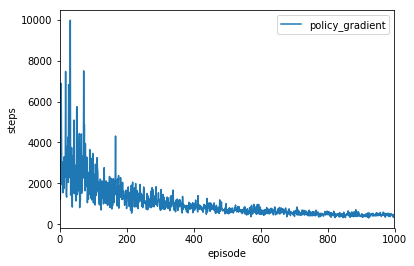

In [13]:
step_result = pd.DataFrame(step_record, columns=['policy_gradient'])
step_result.plot()
plt.xlabel('episode')
plt.ylabel('steps')
plt.show()